In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm

import sys
sys.path.append('../utils')
from utils import *

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
combined_df = retrieve_data()
np.random.seed(42)
n_days = 252
dt = 1 / n_days
close = combined_df[['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']]
tickers = close.columns
log_returns = np.log((close / close.shift(1)).dropna())

# Heston Stochastic Volatility Model 

only use constant interest rate r + does not incorporate option prices into the calibration process.

!!! calibrate based solely on historical stock price data, particularly the realized volatility of returns.

options data need to be collect more on daily basis from 2024/25/07 to 024/25/10.
i only collected on quaterly basis so now cannot right

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from tqdm import tqdm

class HestonModelCalibration:
    def __init__(self, data, n_days=252):
        self.data = data
        self.n_days = n_days
        self.dt = 1 / n_days
        self.tickers = data.columns
        self.log_returns = np.log((data / data.shift(1)).dropna())
        
    def calculate_realized_vol(self, window_size=30):
        """Calculate realized volatility for initial variance"""
        return self.log_returns.rolling(window=window_size).var() * self.n_days
    
    def estimate_correlation_matrix(self, window_size=30):
        """Estimate correlation matrix from historical data"""
        return self.log_returns.iloc[-window_size:].corr().values

    def calibrate_heston_parameters(self, window_size=30):
        """
        Calibrate Heston model parameters using historical data
        Returns dict with parameters for each asset
        """
        params = {}
        for i, ticker in enumerate(self.tickers):
            # Initial estimates based on historical data
            vol = self.calculate_realized_vol()[ticker].dropna()
            
            def objective(x):
                kappa, theta, sigma, rho = x
                var_pred = theta + (vol.iloc[0] - theta) * np.exp(-kappa * np.arange(len(vol)) * self.dt)
                return np.sum((var_pred - vol) ** 2)
            
            bounds = [(0.1, 10.0),  # kappa
                     (0.001, 0.5),  # theta
                     (0.01, 1.0),   # sigma
                     (-0.99, -0.1)] # rho
            
            result = minimize(objective, 
                            x0=[2.0, vol.mean(), 0.3, -0.7],
                            bounds=bounds,
                            method='L-BFGS-B')
            
            params[ticker] = {
                'kappa': result.x[0],
                'theta': result.x[1],
                'sigma': result.x[2],
                'rho': result.x[3]
            }
        
        return params

def MultivariateHestonSimulation(
    s0,
    tickers,
    dt,
    calibrated_params,
    correlation_matrix,
    n_paths=1000,
    last_id=287,
    current_id=187,
    window_size=30,
    variance_reduction='av',
    r=0.01
    ):
    
    n_assets = len(tickers)
    T = dt * (last_id - current_id)
    n_steps = int(T / dt)
    
    # Initialize arrays
    result = np.zeros((n_assets, n_paths, n_steps))
    variance_paths = np.zeros((n_assets, n_paths, n_steps))
    
    # Extract parameters for each asset
    kappa = np.array([calibrated_params[t]['kappa'] for t in tickers])
    theta = np.array([calibrated_params[t]['theta'] for t in tickers])
    sigma = np.array([calibrated_params[t]['sigma'] for t in tickers])
    rho = np.array([calibrated_params[t]['rho'] for t in tickers])
    
    # Get initial variances
    v0 = {t: calibrated_params[t]['theta'] for t in tickers}
    
    # Ensure correlation matrix is 2D numpy array
    if isinstance(correlation_matrix, pd.DataFrame):
        correlation_matrix = correlation_matrix.values
        
    # Cholesky decomposition for correlated Brownian motions
    try:
        chol_corr = np.linalg.cholesky(correlation_matrix)
    except np.linalg.LinAlgError:
        # If matrix is not positive definite, adjust it
        correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2  # Ensure symmetry
        min_eig = np.min(np.real(np.linalg.eigvals(correlation_matrix)))
        if min_eig < 0:
            correlation_matrix -= min_eig * np.eye(correlation_matrix.shape[0])
        chol_corr = np.linalg.cholesky(correlation_matrix)
    
    paths_to_simulate = n_paths // 2 if variance_reduction == 'av' else n_paths
    
    for i in tqdm(range(paths_to_simulate)):
        # Generate and correlate Brownian motions
        dw_s = np.random.normal(size=(n_assets, n_steps))
        dw_v = np.random.normal(size=(n_assets, n_steps))
        dw_s = np.dot(chol_corr, dw_s)
        
        # Correlate price and variance Brownian motions
        for j in range(n_assets):
            dw_v[j] = rho[j] * dw_s[j] + np.sqrt(1 - rho[j]**2) * dw_v[j]
        
        for j in range(n_steps):
            for k in range(n_assets):
                if j == 0:
                    result[k, i, j] = s0[tickers[k]]
                    variance_paths[k, i, j] = v0[tickers[k]]
                    
                    if variance_reduction == 'av':
                        result[k, n_paths - i - 1, j] = s0[tickers[k]]
                        variance_paths[k, n_paths - i - 1, j] = v0[tickers[k]]
                else:
                    v_prev = max(variance_paths[k, i, j-1], 0)
                    
                    # Update variance
                    variance_paths[k, i, j] = (v_prev + 
                        kappa[k] * (theta[k] - v_prev) * dt + 
                        sigma[k] * np.sqrt(v_prev * dt) * dw_v[k, j])
                    
                    # Update price
                    result[k, i, j] = result[k, i, j-1] * np.exp(
                        (r - 0.5 * v_prev) * dt + 
                        np.sqrt(v_prev * dt) * dw_s[k, j])
                    
                    if variance_reduction == 'av':
                        variance_paths[k, n_paths - i - 1, j] = (v_prev + 
                            kappa[k] * (theta[k] - v_prev) * dt + 
                            sigma[k] * np.sqrt(v_prev * dt) * (-dw_v[k, j]))
                        
                        result[k, n_paths - i - 1, j] = result[k, n_paths - i - 1, j-1] * np.exp(
                            (r - 0.5 * v_prev) * dt + 
                            np.sqrt(v_prev * dt) * (-dw_s[k, j]))
    
    if variance_reduction == 'emc':
        for k in range(n_assets):
            correction_factor = result[k][-1, :].mean() / result[k][-1, :]
            result[k] = result[k] * correction_factor
    
    return result, tickers, variance_paths

def run_heston_backtest(combined_df, backtest_start, backtest_end, last_id):
    # Initialize model and calibrate parameters
    close = combined_df[['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']]
    heston_calibration = HestonModelCalibration(close)
    
    prices = []
    for current_id in tqdm(range(backtest_start, backtest_end)):
        # Get data for current window
        window_data = close.iloc[max(0, current_id - 30):current_id]
        
        # Calibrate parameters and get correlation matrix
        calibrated_params = heston_calibration.calibrate_heston_parameters(window_size=30)
        correlation_matrix = heston_calibration.estimate_correlation_matrix(window_size=30)
        
        payoff = []
        result, _, variance_paths = MultivariateHestonSimulation(
            s0=close.iloc[current_id],
            tickers=close.columns,
            dt=1/252,
            calibrated_params=calibrated_params,
            correlation_matrix=correlation_matrix,
            n_paths=1000,
            variance_reduction='av',
            current_id=current_id,
            last_id=last_id
        )
        
        # Construct paths and calculate payoffs
        old_path_rog = combined_df['ROG_Last_Price'].iloc[:current_id]
        old_path_cfr = combined_df['CFR_Last_Price'].iloc[:current_id]
        old_path_zurn = combined_df['ZURN_Last_Price'].iloc[:current_id]

        for i in range(result.shape[1]):
            path_rog = np.append(old_path_rog, result[0][i].flatten())
            path_cfr = np.append(old_path_cfr, result[1][i].flatten())
            path_zurn = np.append(old_path_zurn, result[2][i].flatten())
            
            payoff.append(payoff_func(path_rog, path_cfr, path_zurn, combined_df.iloc[current_id]['Date'], risk_free=0.01107, verbose=False))
        
        prices.append(np.mean(payoff))
    
    return prices

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:10<00:00,  2.17s/it]
d:\mh4518_simulation_in_fin\notebooks\../utils\utils.py:144: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_price['Date'] = pd.to_datetime(real_price['Date'], dayfirst=True)


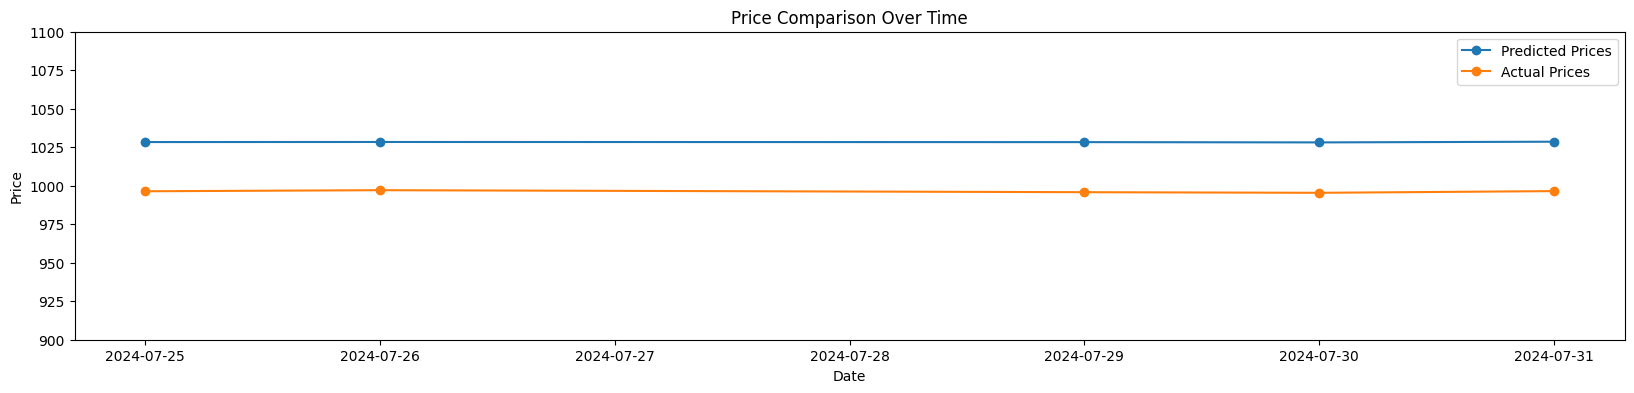

In [4]:
# Initialize backtest parameters
last_id = 287
backtest_start = 187
backtest_end = 192

# Run backtest
prices = run_heston_backtest(
    combined_df,
    backtest_start=187,
    backtest_end=192,
    last_id=287
)

# Evaluate results
evaluation_plot(
    backtest_start,
    backtest_end,
    combined_df,
    prices
)

In [5]:
prices

[1028.3536393102,
 1028.4058287789555,
 1028.30996709327,
 1028.1324722568338,
 1028.582802862832]